# PGOP Example

## Introduction

This example demonstrates the application of Point Group Order Parameter (PGOP) to a Lennard-Jones (LJ) system. The trajectory for this analysis was generated using HOOMD-blue together with dupin ([HOOMD-blue](https://hoomd-blue.readthedocs.io/), [dupin](https://github.com/glotzerlab/dupin)), producing a highly time-resolved subtrajectory of a rare event, where frames are spaced 20 time steps apart. In this LJ system, the rare event we capture is nucleation. You can read more on this in dupin documentation ([link](https://dupin.readthedocs.io/en/latest/index.html)). Our objective is to analyze the evolution of symmetries within the environments found in this trajectory. 

### Identifying Relevant Point Groups

First, we should determine the point groups of interest for PGOP. One approach is to compute the complete set of crystallographic point group symmetries, which is particularly useful for systems with unknown crystal structures. However, applying our prior knowledge of the LJ system, we can expect relatively simple target crystals (BCC, FCC and HCP), each characterized by a single Wyckoff site symmetry. Specifically, BCC and FCC crystals exhibit $\mathrm{O_h}$ point group symmetry, while HCP crystals belong to the $\mathrm{D_{3h}}$ point group. Consequently, this analysis focuses on these two point groups. 

To determine the point group symmetries of particles present in a crystal, one should consult the crystallographic literature. Several comprehensive resources, such as AFLOW ([AFLOW](https://aflow.org/)), provide extensive data on crystal prototypes. A crystal’s symmetry is defined by its space group, which includes both translational and point group symmetries. Each particle in the unit cell is assigned a Wyckoff site designation, which can be linked to a specific point group symmetry using crystallographic tables ([IUCr Tables](https://onlinelibrary.wiley.com/iucr/itc/Ac/contents/)).

Using the referenced tables, the space group of a selected crystal can be identified. Looking under the "Positions" section, Wyckoff sites are listed (e.g., 2c), accompanied by the associated point group symmetry in Hermann-Mauguin notation. PGOP can interpret both Schönflies and Hermann-Mauguin notations for point group designations. For translation between the two systems, [this Wikipedia page](https://en.wikipedia.org/wiki/Hermann%E2%80%93Mauguin_notation) serves as a useful reference. For systems incorporating non-crystallographic symmetries, such as quasicrystals, Hermann-Mauguin notation may be inadequate, and Schönflies notation can be used instead.

### Example: HCP Crystal

As documented by AFLOW, the HCP structure comprises two unique atomic sites, both designated as Wyckoff position 2c ([AFLOW example](https://aflow.org/p/A_hP2_194_c-001/), space group 194). According to the crystallographic tables for this space group ([IUCr Tables for 194](https://onlinelibrary.wiley.com/iucr/itc/Ac/ch2o3v0001/sgtable2o3o194/)), the 2c site exhibits symmetry –$6m2$, which corresponds to $\mathrm{D_{3h}}$ as noted in [Wikipedia](https://en.wikipedia.org/wiki/Hermann%E2%80%93Mauguin_notation).

## Simple example
Let us first consider ideal simple crystals such as SC, BCC, FCC and HCP and
compute their PGOP values.

In [1]:
import warnings

import freud
import numpy as np

import spatula

warnings.filterwarnings("ignore")

crystal_systems = {}
# create crystal systems
crystal_systems["sc"] = freud.data.UnitCell.sc().generate_system(3)
crystal_systems["bcc"] = freud.data.UnitCell.bcc().generate_system(3)
crystal_systems["fcc"] = freud.data.UnitCell.fcc().generate_system(3)
crystal_systems["hcp"] = freud.data.UnitCell(
    freud.box.Box.from_box_lengths_and_angles(
        1, 1, 2 * np.sqrt(6) / 3, np.pi / 2, np.pi / 2, 2 * np.pi / 3
    ),
    [[0, 0, 0], [2 / 3, 1 / 3, 1 / 2]],
).generate_system(3)

crystal_symmetries = {"sc": "Oh", "bcc": "Oh", "fcc": "Oh", "hcp": "D3h"}
# make an optimizer for PGOP
optimizer = spatula.optimize.Union.with_step_gradient_descent(
    spatula.optimize.Mesh.from_grid()
)
sigma = 0.075
# create pgop object that computes both symmetries
pgop_compute = spatula.PGOP(symmetries=["Oh", "D3h"], optimizer=optimizer)
# neighbor list
rad = freud.locality.FilterRAD(
    terminate_after_blocked=True, allow_incomplete_shell=True
)
# symmetry ordering for printing
symmetry_order = {"Oh": 0, "D3h": 1}
perfect_crystal = {}
for crystal in crystal_systems:
    # compute pgop for each system using rad neighbor list
    pgop_compute.compute(
        crystal_systems[crystal],
        sigma,
        rad.compute(crystal_systems[crystal]).filtered_nlist,
    )
    # Print the mean order parameter for the correct symmetry for each crystal.
    mean_order = np.mean(
        pgop_compute.order[:, symmetry_order[crystal_symmetries[crystal]]]
    )
    perfect_crystal[crystal] = np.mean(pgop_compute.order, axis=0)
    print(
        f"{crystal} crystal, PGOP for {crystal_symmetries[crystal]} symmetry: "
        f"{mean_order}"
    )

sc crystal, PGOP for Oh symmetry: 0.9999999999988174
bcc crystal, PGOP for Oh symmetry: 0.9999999999941486
fcc crystal, PGOP for Oh symmetry: 0.9999999999937649
hcp crystal, PGOP for D3h symmetry: 0.9999999999926386


## Perfect crystals with noise

Next, let us attempt to try and separate the structures of these local environments
within all these crystals when we add gaussian noise.

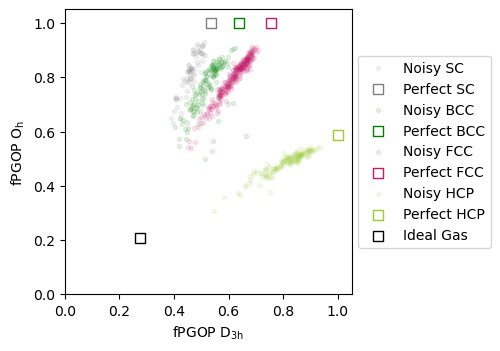

In [2]:
import matplotlib.pyplot as plt

crystal_systems_with_noise = {}
crystal_colors_single = {
    "fcc": "#c7196a",
    "bcc": "green",
    "sc": "gray",
    "hcp": "yellowgreen",
}
# crystal noise
S = 0.0325
# create crystal systems
crystal_systems_with_noise["sc"] = freud.data.UnitCell.sc().generate_system(
    4, sigma_noise=S
)
crystal_systems_with_noise["bcc"] = freud.data.UnitCell.bcc().generate_system(
    4, sigma_noise=S
)
crystal_systems_with_noise["fcc"] = freud.data.UnitCell.fcc().generate_system(
    4, sigma_noise=S
)
crystal_systems_with_noise["hcp"] = freud.data.UnitCell(
    freud.box.Box.from_box_lengths_and_angles(
        1, 1, 2 * np.sqrt(6) / 3, np.pi / 2, np.pi / 2, 2 * np.pi / 3
    ),
    [[0, 0, 0], [2 / 3, 1 / 3, 1 / 2]],
).generate_system(4, sigma_noise=S)

crystal_symmetries = {"sc": "Oh", "bcc": "Oh", "fcc": "Oh", "hcp": "D3h"}
# make an optimizer for PGOP
optimizer = spatula.optimize.Union.with_step_gradient_descent(
    spatula.optimize.Mesh.from_grid()
)
sigma = 0.075
# create pgop object that computes both symmetries
pgop_compute = spatula.PGOP(symmetries=["Oh", "D3h"], optimizer=optimizer)
rad = freud.locality.FilterRAD(
    terminate_after_blocked=True, allow_incomplete_shell=True
)
# symmetry ordering for printing
symmetry_order = {"Oh": 0, "D3h": 1}
noisy_crystal = {}
for crystal in crystal_systems:
    # compute pgop for each system
    pgop_compute.compute(
        crystal_systems_with_noise[crystal],
        sigma,
        rad.compute(crystal_systems_with_noise[crystal]).filtered_nlist,
    )
    noisy_crystal[crystal] = pgop_compute.order
ideal_gas_system = freud.data.make_random_system(4, 256)
pgop_compute.compute(ideal_gas_system, sigma, {"r_max": 1.1, "exclude_ii": True})
ideal_gas_coordinate = np.mean(pgop_compute.order, axis=0)
fig, ax = plt.subplots(figsize=(3.7, 3.7))
# Define grid for contour
x_min, x_max = 0, 1
y_min, y_max = 0, 1

for crystal in perfect_crystal:
    x = np.array(noisy_crystal[crystal][:, 1])
    y = np.array(noisy_crystal[crystal][:, 0])
    ax.scatter(
        x,
        y,
        marker=".",
        c=crystal_colors_single[crystal],
        label=f"Noisy {crystal.upper()}",
        alpha=0.1,
    )
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1.05)
    ax.scatter(
        perfect_crystal[crystal][1],
        perfect_crystal[crystal][0],
        label=f"Perfect {crystal.upper()}",
        edgecolors=crystal_colors_single[crystal],
        marker="s",
        s=50,
        facecolors="white",
    )
ax.scatter(
    ideal_gas_coordinate[1],
    ideal_gas_coordinate[0],
    label="Ideal Gas",
    edgecolors="black",
    marker="s",
    s=50,
    facecolors="white",
)
ax.set_xlabel(r"fPGOP $\mathregular{D_{3h}}$")
ax.set_ylabel(r"fPGOP $\mathregular{O_h}$")
# plot legend outside of plot
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

## LJ nucleation analysis

Now let us analyze the promised nucleation subtrajectory of LJ system. First step is to
compute the value of the order parameter for every particle in every frame. This might
take up to half an hour for a typical laptop computer.

In [3]:
import gsd.hoomd

# make an optimizer for PGOP
optimizer = spatula.optimize.Union.with_step_gradient_descent(
    spatula.optimize.Mesh.from_grid()
)
sigma = 0.075
# create pgop object that computes both symmetries
pgop_compute = spatula.PGOP(symmetries=["Oh", "D3h"], optimizer=optimizer)
# neighbor list
rad = freud.locality.FilterRAD(
    terminate_after_blocked=True, allow_incomplete_shell=True
)
PGOP_values = []
with gsd.hoomd.open("nucleation.gsd") as f:
    for frame in f:
        box = frame.configuration.box
        points = frame.particles.position
        # compute custom neighbor list
        nlist = (
            freud.AABBQuery.from_system((box, points))
            .query(points, {"mode": "ball", "r_max": 3.0, "exclude_ii": True})
            .toNeighborList()
        )
        # compute rad neighbor list
        nlist_rad = rad.compute((box, points), neighbors=nlist).filtered_nlist
        pgop_compute.compute(
            (frame.configuration.box, frame.particles.position),
            sigma,
            nlist_rad,
        )
        PGOP_values.append(pgop_compute.order)

Let us plot the progression of the mean values for each frame as the simplest example.

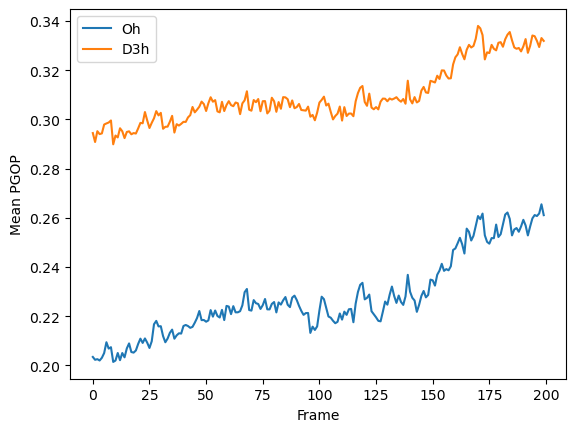

In [4]:
import matplotlib.pyplot as plt

mean_Oh = np.mean(np.array(PGOP_values)[:, :, symmetry_order["Oh"]], axis=1)  # noqa: N816
mean_D3h = np.mean(np.array(PGOP_values)[:, :, symmetry_order["D3h"]], axis=1)  # noqa: N816

plt.plot(mean_Oh, label="Oh")
plt.plot(mean_D3h, label="D3h")
plt.legend()
plt.xlabel("Frame")
plt.ylabel("Mean PGOP")
plt.show()

## Detailed per-particle analysis
The true power of PGOP lies in the fact that it is a per-particle order parameter, which
enables us to quantify the development of particle environments as a function of time
for key particles during nucleation.


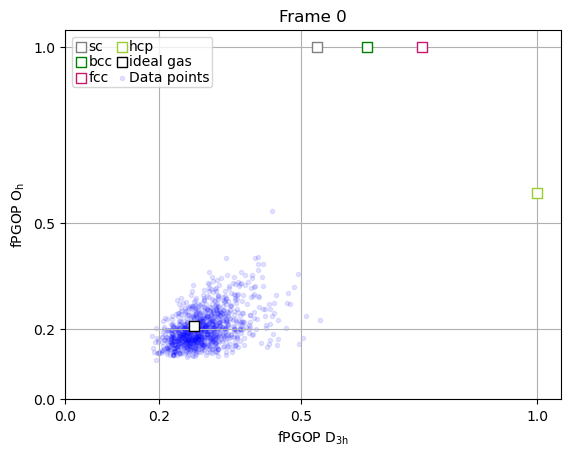

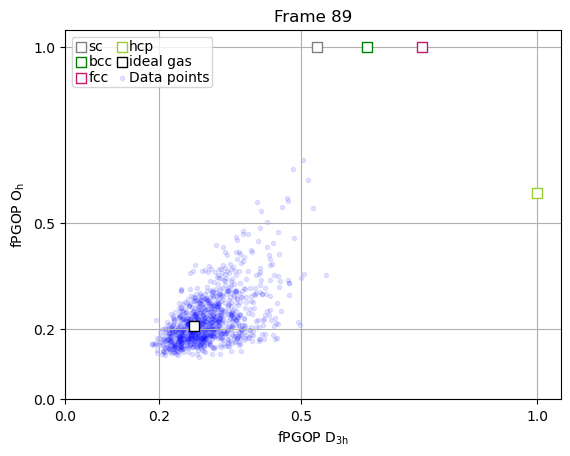

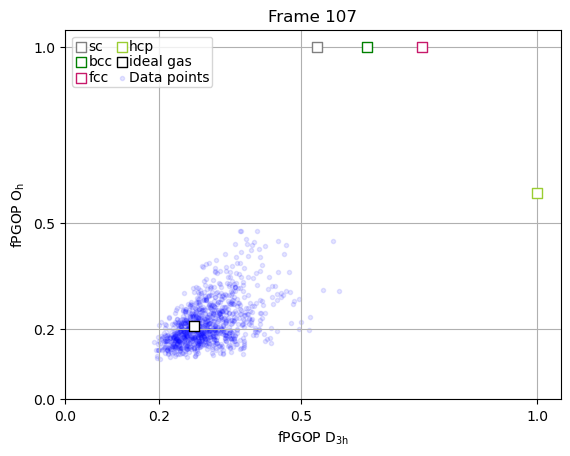

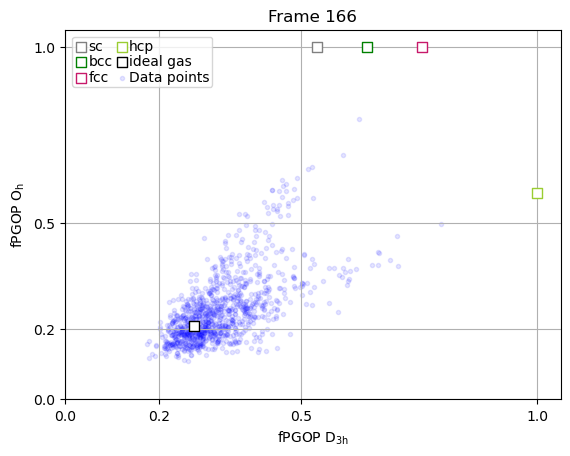

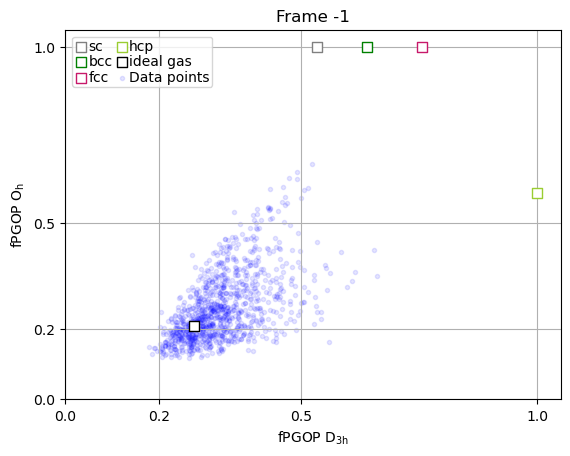

In [5]:
frames_to_plot = [0, 89, 107, 166, -1]
for ii in frames_to_plot:
    x = np.array(PGOP_values[ii][:, 1])
    y = np.array(PGOP_values[ii][:, 0])
    fig, ax = plt.subplots()
    for crystal in perfect_crystal:
        ax.scatter(
            perfect_crystal[crystal][1],
            perfect_crystal[crystal][0],
            label=crystal,
            marker="s",
            edgecolors=crystal_colors_single[crystal],
            s=50,
            facecolors="white",
            zorder=10000,
        )
    ax.scatter(
        ideal_gas_coordinate[1],
        ideal_gas_coordinate[0],
        label="ideal gas",
        marker="s",
        edgecolors="black",
        s=50,
        facecolors="white",
        zorder=10000,
    )
    # set title to be frame number
    ax.set_title(f"Frame {ii}")
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_yticks([0.0, 0.2, 0.5, 1.0])
    ax.set_xticks([0.0, 0.2, 0.5, 1.0])
    ax.set_xlabel(r"fPGOP $\mathregular{D_{3h}}$")
    ax.set_ylabel(r"fPGOP $\mathregular{O_h}$")
    # Initialize dynamic scatter plot for data points
    # We'll initialize with empty data; it will be updated in the animation
    ax.scatter(x, y, marker=".", c="blue", alpha=0.1)
    #  add legend entry for scatter plot
    ax.scatter([], [], marker=".", c="blue", alpha=0.1, label="Data points")
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1.05)
    ax.legend(
        ncol=2,
        handletextpad=0,
        columnspacing=0.2,
        handlelength=1,
        labelspacing=0.1,
        borderpad=0.2,
    )
    ax.grid(True)